In [1]:
import sys; sys.path.append("../../wwa"); from wwa import *

mapproj = cartopy.crs.PlateCarree()

fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/FS_heat/"

Xn,Xx,Yn,Yx = [0,35,55,75]
xn,xx,yn,yx = [4,30,60,72]

In [2]:
sf = gpd.read_file(fpath+"sf_sweden-adm1")
norrland = sf.iloc[[0,1,2,6,7]].dissolve()
norrland.to_file(fpath+"sf_norrland")

# Get coordinates of sites where records were observed

In [3]:
# locations of records
sites = pd.read_csv("fs-heat-records.csv", index_col = "Site")

In [ ]:
px = pd.DataFrame.from_dict({k : get_latlon(k+", "+r.Country) for k,r in sites.iterrows()}).transpose()

sites = merge_byindex([sites, px])
sites.to_csv("fs-heat-records_with-coords.csv")

In [4]:
sites

,temp,rtype,Country
Site,,,
Sunndalsora,33.1,max,Norway
Stryn,32.1,max,Norway
Sandane,31.9,max,Norway
Jomfruland,29.6,max,Norway
Nordoyan,27.6,max,Norway
...,...,...,...
Oppdal,19.0,min,Norway
Mannen,17.2,min,Norway
Krinstiansund,21.1,min,Norway


In [ ]:
# list of names that were updated manually from the original reported list
# corrected_names =  ["Meraker, Norway","Sunndalsora, Norway", "Varkaus, Finland", "Hailuoto, Finland", "Raahe, Finland", 
#                     "Ruukki, Finland", "Buholmrasa, Norway", "Skelleftea, Sweden", "Sarpsborg, Norway"]

In [ ]:
sites

In [ ]:
fig, ax = plt.subplots(figsize = (6,6), subplot_kw = {"projection" : mapproj, "extent" : (Xn,Xx,Yn,Yx)}, dpi = 100)

for rt in ["min", "max"]:
    ax.scatter(sites.loc[sites.rtype == rt, "lon"], sites.loc[sites.rtype == rt, "lat"], marker = "x")

ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])

ax.legend(["Min temp records", "Max temp records"], loc = "upper left", edgecolor = "w")
plt.savefig("fig/record-locations.png")

# Map of daily anomalies during June

In [91]:
tx = wrap_lon(xr.open_dataset(fpath+"era5_tmax_daily_eu_extended_0-35E_55-75N_-999-lastyear.nc").tmax)
lsm = xr.open_dataset(fpath+"era5_000000_lsm_eu.nc").lsm.squeeze(drop = True).rename(latitude = "lat", longitude = "lon").sel(lon = tx.lon, lat = tx.lat)
tx = tx.where(lsm > 0.5)

tx_clim07 = tx.groupby("time.month")[7].sel(time = slice("1990","2020")).mean("time")
anom = tx.sel(time = "2025-07") - tx_clim07

In [82]:
px = pd.DataFrame.from_dict({s : get_latlon(s) for s in ["Stockholm", "Oslo"]}).transpose()

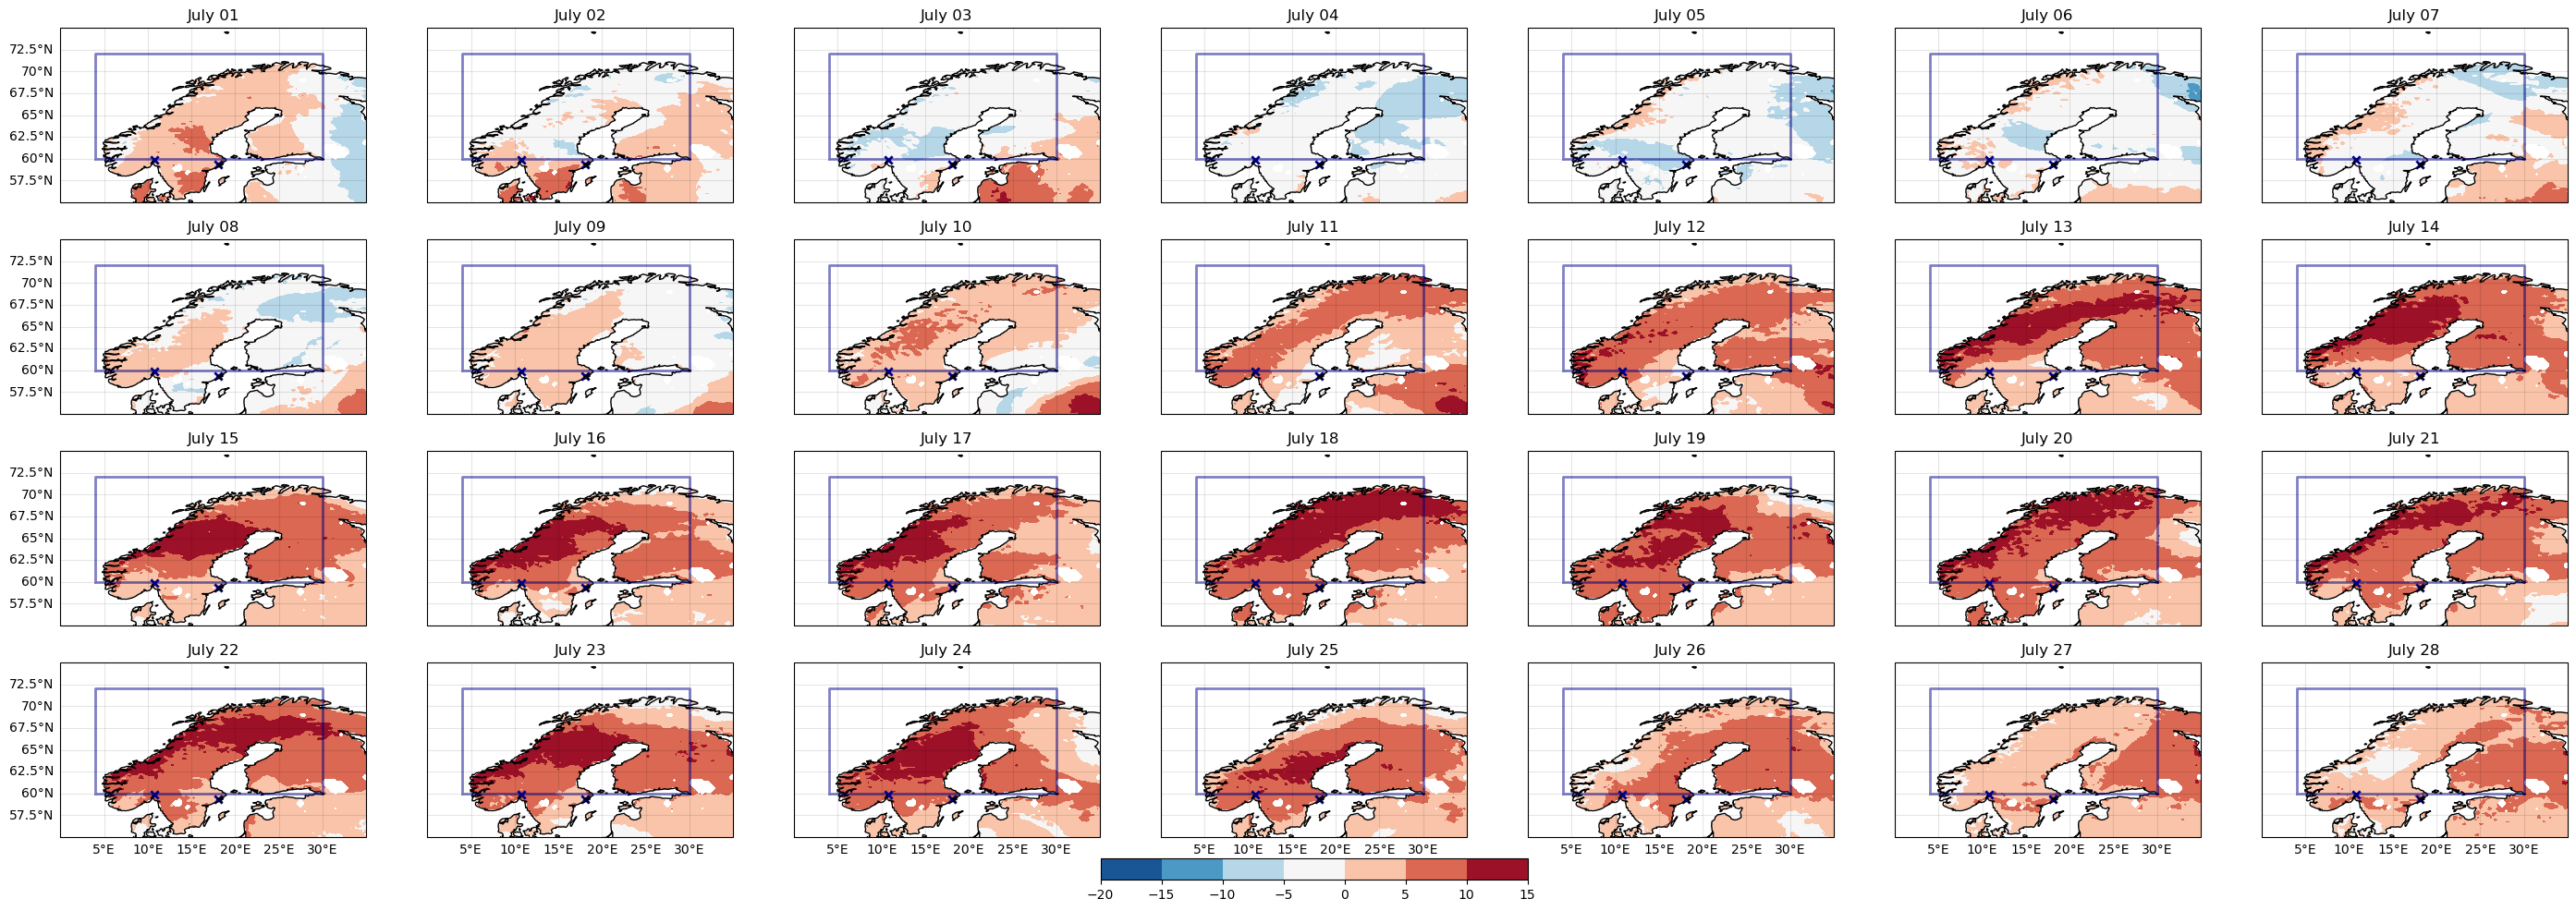

In [89]:
nc = 7; nr = 4

xn,xx,yn,yx = [4,30,60,72]

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 5, nr * 3), subplot_kw = {"projection" : mapproj})

for i in range(nc*nr):
    ax = axs.flatten()[i]
    da = anom.sel(time = "2025-07").isel(time = i)
    
    cbar = ax.contourf(da.lon, da.lat, da, levels = range(-20,20,5), cmap = "RdBu_r")
    ax.coastlines()
    ax.set_title(da.time.dt.strftime("%B %d").values)
    ax.gridlines(color = "k", alpha = 0.1)
    
    ax.scatter(px.lon, px.lat, marker = "x", color = "darkblue", lw = 2)
    
    ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "darkblue", lw = 2, alpha = 0.5)
    
for ax in axs[-1,:]: ax.gridlines(alpha = 0, draw_labels = ["bottom"])
for ax in axs[:,0]: ax.gridlines(alpha = 0, draw_labels = ["left"])

    
plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.025, pad = 0.025)

# Seasonal cycle

In [94]:
ts = tx.sel(lon = slice(xn,xx), lat = slice(yn,yx)).mean(["lat", "lon"])

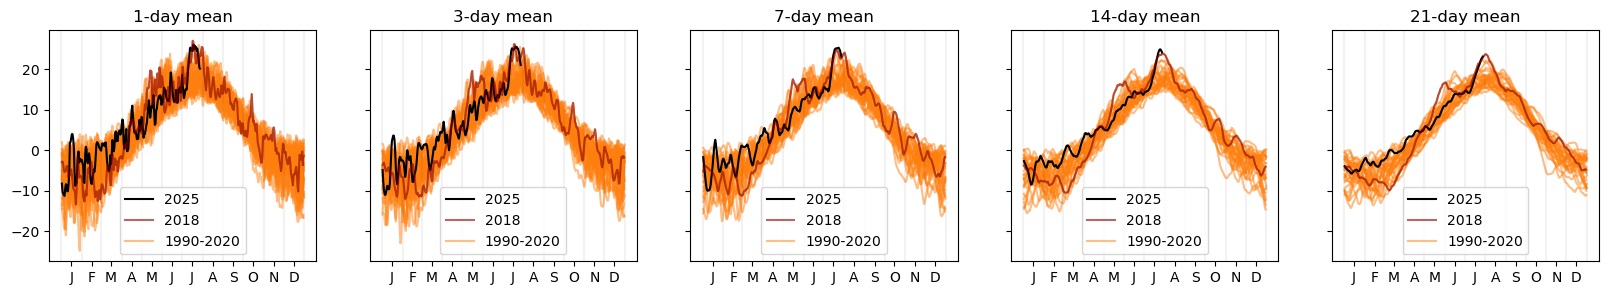

In [136]:
ndays = [1,3,7,14,21]

nc = len(ndays); nr = 1
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*4, nr*3), dpi = 100, sharex = True, sharey = True)
plt.subplots_adjust(hspace = 0.35)

days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 15]

for i in range(nc):
    ax = axs[i]
    nd = ndays[i]
    
    ts_nday = ts.rolling(time = nd).mean()
    
    y = 2025; ts_y = ts_nday.sel(time = ts.time.dt.year == y); ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k", label = "2025", zorder = 99)
    y = 2018; ts_y = ts_nday.sel(time = ts.time.dt.year == y); ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "darkred", alpha = 0.6, label = "2018", zorder = 99)

    for y in range(1990,2020):
        ts_y = ts_nday.sel(time = ts.time.dt.year == y)
        ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:orange", alpha = 0.5, label = "_years")
        
    ax.set_title(str(nd)+"-day mean")

    ax.legend(["2025", "2018", "1990-2020"])
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]

# ylim = ax.get_ylim()
# ax.add_patch(Rectangle((77, 0), 10, ylim[1]+10, color = "gold", alpha = 0.3))
# ax.set_ylim(ylim)

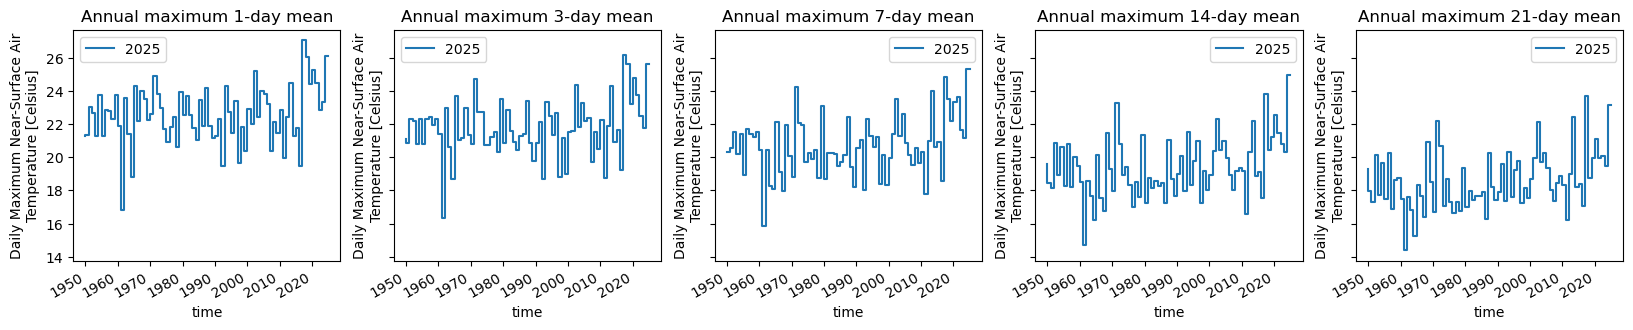

In [134]:
nc = len(ndays); nr = 1
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*4, nr*3), dpi = 100, sharex = True, sharey = True)
plt.subplots_adjust(hspace = 0.35)

days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 15]

for i in range(nc):
    ax = axs[i]
    nd = ndays[i]
    
    txnx = ts.rolling(time = nd).mean().resample(time = "AS").max()
    txnx.plot(ax = ax, drawstyle = "steps")
        
    ax.set_title("Annual maximum "+str(nd)+"-day mean")

    ax.legend(["2025", "1990-2020"])


# Map of gridded trend

In [14]:
fnm = "gridded-trend_tx14x_era5.nc"

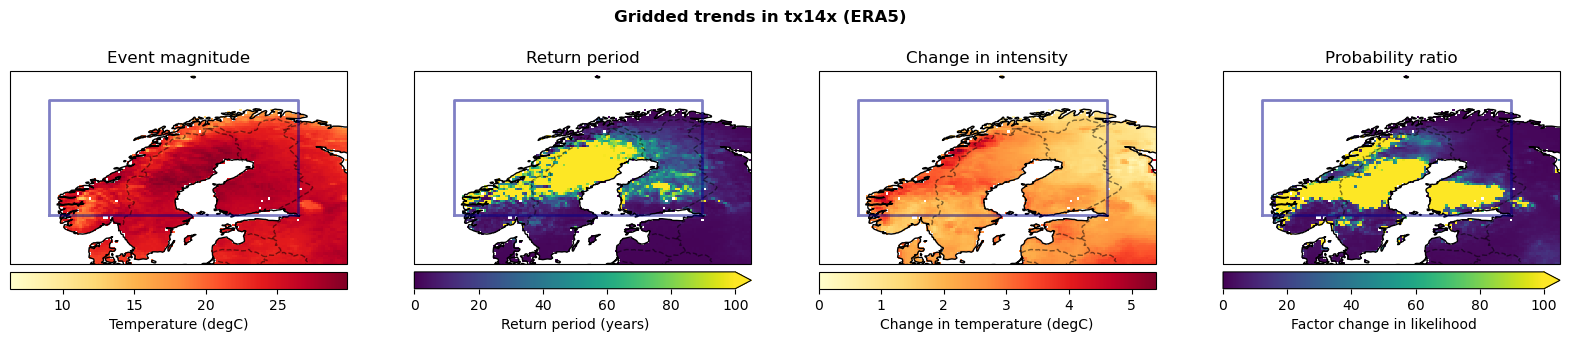

In [19]:
res = xr.open_dataset(fnm)

fig, axs = plt.subplots(ncols = 4, figsize = (20,5), dpi = 100, subplot_kw = {"projection" : mapproj})

cbar_kwargs = {"location" : "bottom", "pad" : 0.02}

res.event_magnitude.plot(ax = axs[0], cmap = "YlOrRd", cbar_kwargs = cbar_kwargs | {"label" : "Temperature (degC)"})
axs[0].set_title("Event magnitude")

res.return_period.plot(ax = axs[1], cmap = "viridis", vmin = 0, vmax = 100, cbar_kwargs = cbar_kwargs | {"label" : "Return period (years)"})
axs[1].set_title("Return period")

res.dI_abs.plot(ax = axs[2], cmap = "YlOrRd", vmin = 0, cbar_kwargs = cbar_kwargs | {"label" : "Change in temperature (degC)"})
axs[2].set_title("Change in intensity")

res.PR.plot(ax = axs[3], cmap = "viridis", vmin = 0, vmax = 100, cbar_kwargs = cbar_kwargs | {"label" : "Factor change in likelihood"})
axs[3].set_title("Probability ratio")

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
    ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "darkblue", lw = 2, alpha = 0.5)
    
plt.suptitle("Gridded trends in "+fnm.split("_")[1]+" ("+fnm.split("_")[-1][:-3].upper()+")", fontweight = "bold", y = 0.75)
    
plt.savefig("fig/"+fnm[:-3]+".png")